In [52]:
import numpy as np
import matplotlib.pyplot as plt

# PID Class

In [53]:
class PID:
    def __init__(self, Kp, Ki, Kd, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0
        self.prev_error = 0

    def compute(self, setpoint, measured):
        error = setpoint - measured
        self.integral += error * self.dt
        self.integral = np.clip(self.integral, -100, 100)  # Anti-windup
        derivative = (error - self.prev_error) / self.dt
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

# Functions Definition

In [ ]:
def simulate_drone(N, dt, setpoints, pid_pitch, pid_roll, pid_yaw, pid_thrust):
    # Constants
    k_T = 1e-6  # thrust coefficient
    k_D = 1e-6  # drag coefficient
    d = 0.1    # arm length for yaw control (distance from center to motor)
    l = 0.1     # arm length [m]
    I_x = 0.002 # moment of inertia around X (pitch)
    I_y = 0.002 # moment of inertia around Y (roll)
    I_z = 0.004 # moment of inertia around Z (yaw)

    # State
    theta = phi = psi = thrust = 0           # pitch, roll, yaw
    omega_pitch = omega_roll = omega_yaw = 0

    state_history = {
        "theta": [], "phi": [], "psi": [],
        "motor_omegas": []
    }

    # Initial motor speeds
    omega_hover = 300  # base speed to hover
    omegas = np.ones(4) * omega_hover

    for k in range(N):
        set_theta, set_phi, set_psi, set_thrust = setpoints[k]

        # --- Compute control signals
        u_pitch = pid_pitch.compute(set_theta, theta)
        u_roll = pid_roll.compute(set_phi, phi)
        u_yaw = pid_yaw.compute(set_psi, psi)
        u_thrust = pid_thrust.compute(set_thrust, thrust)

        # --- Adjust motor speeds (simplified mixer)
        # [M1, M2, M3, M4] (quad X)
        omegas[0] = u_thrust - u_pitch - u_roll - u_yaw
        omegas[1] = u_thrust - u_pitch + u_roll + u_yaw
        omegas[2] = u_thrust + u_pitch - u_roll + u_yaw
        omegas[3] = u_thrust + u_pitch + u_roll - u_yaw

        # Saturation (simulate motor limits)
        omegas = np.clip(omegas, 200, 500)

        # --- Compute thrusts
        T = k_T * omegas**2
        τ_pitch = l * ((T[2] + T[3]) - (T[0] + T[1]))
        τ_roll  = l * ((T[1] + T[3]) - (T[0] + T[2]))
        T_lateral = k_D * omegas**2  # lateral drag (yaw control)
        τ_yaw   = d * ((T_lateral[1] + T_lateral[2]) - (T_lateral[0] + T_lateral[3]))

        # --- Integrate angular motion
        alpha_pitch = τ_pitch / I_x
        alpha_roll  = τ_roll  / I_y
        alpha_yaw   = τ_yaw   / I_z

        omega_pitch += dt * alpha_pitch
        omega_roll  += dt * alpha_roll
        omega_yaw   += dt * alpha_yaw

        theta += dt * omega_pitch
        phi   += dt * omega_roll
        psi   += dt * omega_yaw
        
        # --- Compute thrust

        # --- Save state
        state_history["theta"].append(theta)
        state_history["phi"].append(phi)
        state_history["psi"].append(psi)
        state_history["thrust"].append()
        state_history["motor_omegas"].append(omegas.copy())

    return state_history

def logFile_to_array(log_file):
    """
    Convert a log file to a numpy array.
    The log file is expected to have space-separated values.
    """
    with open(log_file, 'r') as f:
        lines = f.readlines()
        lines = lines[1:]
    return np.array([list(map(float, line.split(','))) for line in lines])

log_array = logFile_to_array("../logFile.csv")
# timestamp,M1,M2,M3,M4,pitch,roll,yaw,thrust

# Model adaptation

# Simulation Settings

In [55]:
dt = 0.01
N = np.size(log_array, 0)  # Total time based on log file length
T_total = N * dt  # Total simulation time
time = np.linspace(0, T_total, N)

# Setpoints: sinusoidal command for pitch/roll/yaw
setpoints = np.zeros((N, 4))
setpoints[:, 0] = 0.1 * np.sin(2 * np.pi * 0.2 * time)   # pitch
setpoints[:, 1] = 0.1 * np.sin(2 * np.pi * 0.1 * time)   # roll
setpoints[:, 2] = 0.2 * np.sin(2 * np.pi * 0.15 * time)  # yaw
setpoints[:, 3] = 0.2 * np.sin(2 * np.pi * 0.15 * time)  # thrust

# PID Controllers settings

In [56]:
pid_pitch = PID(Kp=300, Ki=50, Kd=20, dt=dt)
pid_roll  = PID(Kp=300, Ki=50, Kd=20, dt=dt)
pid_yaw   = PID(Kp=150, Ki=30, Kd=10, dt=dt)
pid_thrust   = PID(Kp=150, Ki=30, Kd=10, dt=dt)

# Run Simulation and plot

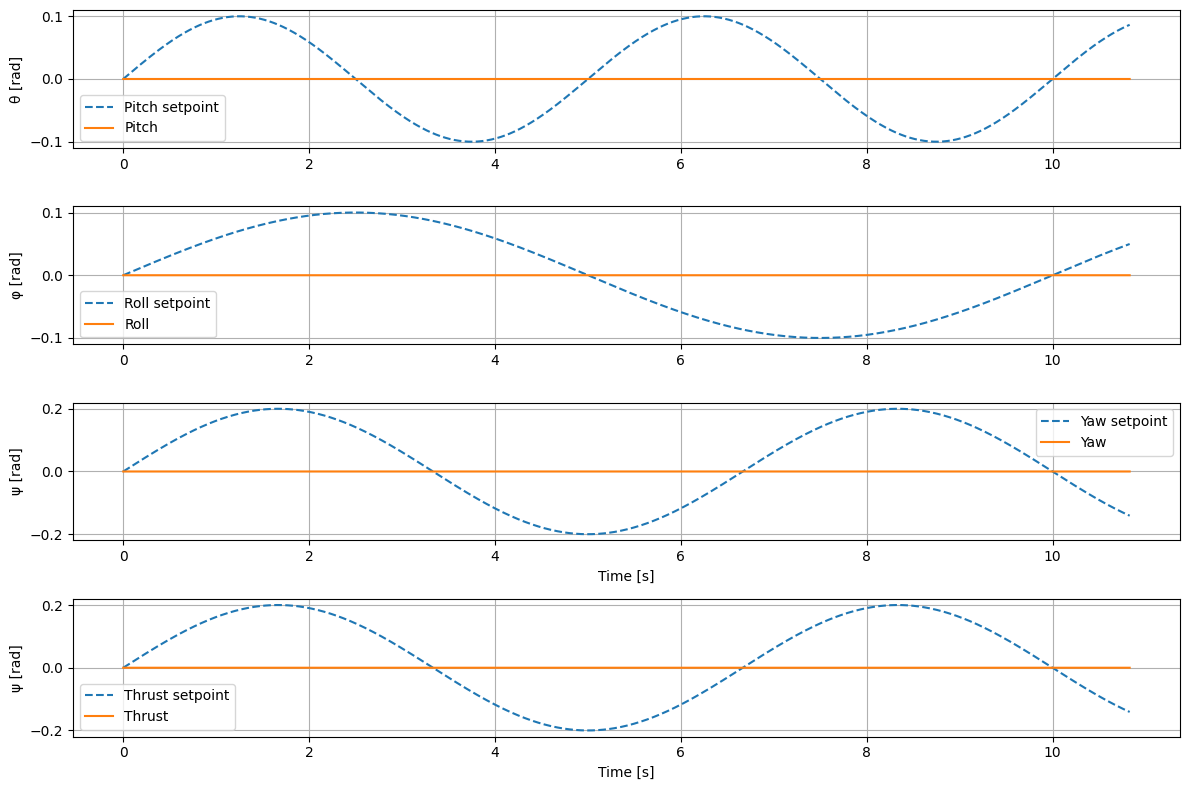

In [57]:
# --- Run simulation
states = simulate_drone(N, dt, setpoints, pid_pitch, pid_roll, pid_yaw, pid_thrust)

# --- Plot results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time, setpoints[:, 0], '--', label="Pitch setpoint")
plt.plot(time, states["theta"], label="Pitch")
plt.legend(); plt.grid(); plt.ylabel("θ [rad]")

plt.subplot(4, 1, 2)
plt.plot(time, setpoints[:, 1], '--', label="Roll setpoint")
plt.plot(time, states["phi"], label="Roll")
plt.legend(); plt.grid(); plt.ylabel("φ [rad]")

plt.subplot(4, 1, 3)
plt.plot(time, setpoints[:, 2], '--', label="Yaw setpoint")
plt.plot(time, states["psi"], label="Yaw")
plt.legend(); plt.grid(); plt.ylabel("ψ [rad]"); plt.xlabel("Time [s]")

plt.subplot(4, 1, 4)
plt.plot(time, setpoints[:, 3], '--', label="Thrust setpoint")
plt.plot(time, states["psi"], label="Thrust")
plt.legend(); plt.grid(); plt.ylabel("ψ [rad]"); plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()